# Effectiveness of increasing ensemble size:

In [6]:
import pandas as pd
from pathlib import Path

rows = []

for csv_path in Path('.').glob('*.csv'):
    df = pd.read_csv(csv_path)

    # Normalise to real booleans even if values are the strings "True"/"False"
    df['ex_flag']        = df['ex_flag'].astype(str).str.lower() == 'true'
    df['recover_ex_flag'] = df['recover_ex_flag'].astype(str).str.lower() == 'true'

    by_q = df.groupby('question')

    ex_acc_questions         = by_q['ex_flag'].any().sum()          # at least one attempt got ex_flag == True
    recover_ex_acc_questions = by_q['recover_ex_flag'].any().sum()  # at least one attempt got recover_ex_flag == True
    total_questions          = by_q.ngroups

    rows.append({
        'file'                       : csv_path.name,
        'ex_acc_questions'           : ex_acc_questions,
        'recover_ex_acc_questions'   : recover_ex_acc_questions,
        'total_questions'            : total_questions,
        'ex_acc_rate'                : ex_acc_questions / total_questions,
        'recover_ex_acc_rate'        : recover_ex_acc_questions / total_questions
    })

summary = pd.DataFrame(rows).set_index('file').sort_index()
summary

,ex_acc_questions,recover_ex_acc_questions,total_questions,ex_acc_rate,recover_ex_acc_rate
file,,,,,
ensemble_1.csv,907,932,949,0.955743,0.982086
ensemble_3.csv,906,934,949,0.954689,0.984194
ensemble_5.csv,909,934,949,0.957850,0.984194
ensemble_7.csv,911,936,949,0.959958,0.986301
ensemble_9.csv,911,937,949,0.959958,0.987355


<Axes: xlabel='file'>

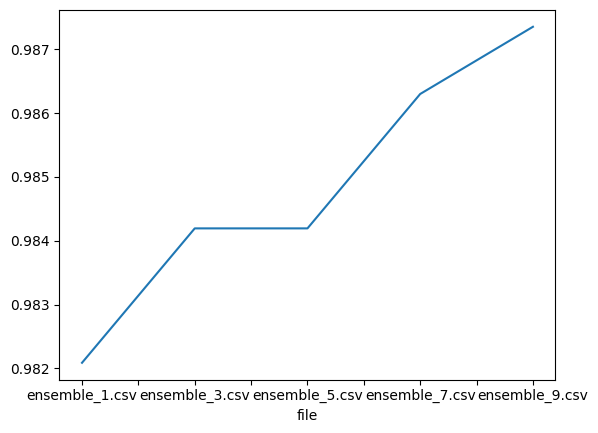

In [7]:
summary['recover_ex_acc_rate'].plot()

# Control:
### 2/3 ensemble size 1, 1/3 ensemble size 7
### Assigned randomly

In [10]:
import pandas as pd, numpy as np, ast, re
from pathlib import Path

# ── 0. reproducible randomness ────────────────────────────────────────────────
rng  = np.random.default_rng(seed=42)          # change / remove seed if you want

# ── 1. locate all "*seeds_5samples*" CSVs and map size→file ───────────────────
csvs = {
    int(re.search(r'_(\d+)', p.name).group(1)): p
    for p in Path('.').glob('*.csv')
}
needed = {1, 3, 5, 7}
missing = needed - csvs.keys()
if missing:
    raise FileNotFoundError(f"Missing ensemble files for sizes: {sorted(missing)}")

dfs = {sz: pd.read_csv(csvs[sz]) for sz in needed}

# ── 2. helpers ────────────────────────────────────────────────────────────────
to_bool = lambda x: str(x).lower() == 'true'
for df in dfs.values():
    df['ex_flag']         = df['ex_flag'].apply(to_bool)
    df['recover_ex_flag'] = df['recover_ex_flag'].apply(to_bool)

# ── 3. one-row-per-question correctness for all sizes ─────────────────────────
acc = {sz: {} for sz in needed}
for sz, df in dfs.items():
    g = df.groupby('question')
    acc[sz]['ex']        = g['ex_flag'].any()
    acc[sz]['recovered'] = g['recover_ex_flag'].any()

all_qs = acc[1]['ex'].index                               # questions universe
for sz in acc:
    for kind in ('ex', 'recovered'):
        acc[sz][kind] = acc[sz][kind].reindex(all_qs, fill_value=False)

# ── 4. RANDOMLY choose the same fraction (≈⅓) to upgrade to ensemble-7 ────────
N  = len(all_qs)
k  = N // 3                                               # same compute budget
top_qs = rng.choice(all_qs, size=k, replace=False)        # random subset

# ── 5. build blended vectors (start with ensemble-1, overwrite with 7) ────────
blend = {}
for kind in ('ex', 'recovered'):
    v = acc[1][kind].copy()
    v.loc[top_qs] = acc[7][kind].loc[top_qs]
    blend[kind] = v

# ── 6. accuracy table & compute budget check ──────────────────────────────────
def avg(series): return series.mean()

rows = []
for label, src in [('ensemble-1',   acc[1]),
                   ('ensemble-3',   acc[3]),
                   ('ensemble-5',   acc[5]),
                   ('ensemble-7',   acc[7]),
                   ('blend (1→7 random)', blend)]:
    rows.append({
        'setup'            : label,
        'ex_acc'           : avg(src['ex']),
        'recover_ex_acc'   : avg(src['recovered'])
    })

out = pd.DataFrame(rows).set_index('setup')

compute_blend = 7*k + 1*(N-k)           # should equal 3*N
compute_e3    = 3*N

print(f'Total questions             : {N}')
print(f'Random questions at ens-7   : {k}  ({k/N:.1%})')
print(f'Compute  blend vs all-size-3: {compute_blend} vs {compute_e3}  '
      f'→ ratio {compute_blend/compute_e3:.2f}')
print('--------------------------------------------------------------------')
display(out.style.format('{:.4f}'))

Total questions             : 949
Random questions at ens-7   : 316  (33.3%)
Compute  blend vs all-size-3: 2845 vs 2847  → ratio 1.00
--------------------------------------------------------------------


,ex_acc,recover_ex_acc
setup,,
ensemble-1,0.9557,0.9821
ensemble-3,0.9547,0.9842
ensemble-5,0.9579,0.9842
ensemble-7,0.9600,0.9863
blend (1→7 random),0.9557,0.9821


# "Uncertainty Aware" Test-Time Scaling
### Top 1/3 most data uncertainty -> ensemble size 7
### Rest -> ensemble size 1

In [11]:
# ── 2. helpers ────────────────────────────────────────────────────────────────
to_bool = lambda x: str(x).lower() == 'true'
row_unc = lambda s: np.mean(ast.literal_eval(s))        # mean of list in total_uncertainty

for df in dfs.values():
    df['ex_flag']         = df['ex_flag'].apply(to_bool)
    df['recover_ex_flag'] = df['recover_ex_flag'].apply(to_bool)

dfs[1]['unc'] = dfs[1]['total_uncertainty'].apply(row_unc)  # uncertainty comes from ens-1

# ── 3. aggregate to one row per *question* (any-attempt correctness) ──────────
acc = {sz: {} for sz in needed}
for sz, df in dfs.items():
    g = df.groupby('question')
    acc[sz]['ex']        = g['ex_flag'].any()
    acc[sz]['recovered'] = g['recover_ex_flag'].any()

unc_q = dfs[1].groupby('question')['unc'].mean()
all_qs = unc_q.index
for sz in acc:
    for kind in ('ex', 'recovered'):
        acc[sz][kind] = acc[sz][kind].reindex(all_qs, fill_value=False)
unc_q = unc_q.reindex(all_qs)

# ── 4. pick top-⅓ most-uncertain questions to upgrade to ensemble-7 ──────────
N  = len(all_qs)
k  = N // 3
top_qs = unc_q.sort_values(ascending=False).head(k).index

# ── 5. build blended vectors (start from ensemble-1, overwrite with 7) ────────
blend = {}
for kind in ('ex', 'recovered'):
    v = acc[1][kind].copy()
    v.loc[top_qs] = acc[7][kind].loc[top_qs]
    blend[kind] = v

# ── 6. accuracy table & compute sanity check ──────────────────────────────────
def avg(series): return series.mean()

rows = []
for label, src in [('ensemble-1',   acc[1]),
                   ('ensemble-3',   acc[3]),
                   ('ensemble-5',   acc[5]),
                   ('ensemble-7',   acc[7]),
                   ('blend (1→7)', blend)]:
    rows.append({
        'setup'            : label,
        'ex_acc'           : avg(src['ex']),
        'recover_ex_acc'   : avg(src['recovered'])
    })

out = pd.DataFrame(rows).set_index('setup')

compute_blend = 7*k + 1*(N-k)          # cost units
compute_e3    = 3*N

print(f'Total questions             : {N}')
print(f'Questions at ensemble-7     : {k}  ({k/N:.1%})')
print(f'Compute  blend vs all-size-3: {compute_blend} vs {compute_e3}  '
      f'→ ratio {compute_blend/compute_e3:.2f}')
print('--------------------------------------------------------------------')
display(out.style.format('{:.4f}'))

Total questions             : 949
Questions at ensemble-7     : 316  (33.3%)
Compute  blend vs all-size-3: 2845 vs 2847  → ratio 1.00
--------------------------------------------------------------------


,ex_acc,recover_ex_acc
setup,,
ensemble-1,0.9557,0.9821
ensemble-3,0.9547,0.9842
ensemble-5,0.9579,0.9842
ensemble-7,0.9600,0.9863
blend (1→7),0.9589,0.9863
